In [53]:
%load_ext autoreload
%autoreload 2

# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF, TruncatedSVD

# custom
from reflectance import file_ops, optimisation_pipeline, plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualise library

In [54]:
# read in spectral library
f = file_ops.RESOURCES_DIR_FP / "spectral_library_clean_v3_PRISM_wavebands.csv"
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)

In [55]:
df.columns

Index([390.3468145, 393.1778586, 396.0089588, 398.8401154, 401.6713281,
       404.5025971, 407.3339224, 410.1653038, 412.9967416, 415.8282355,
       ...
       682.2397794, 685.0766161, 687.9135091, 690.7504584, 693.5874638,
       696.4245256, 699.2616435, 702.0988177, 704.9360482, 707.7733348],
      dtype='float64', length=113)

In [56]:
rgb_normed = plotting.generate_and_visualise_spectral_colours(df)

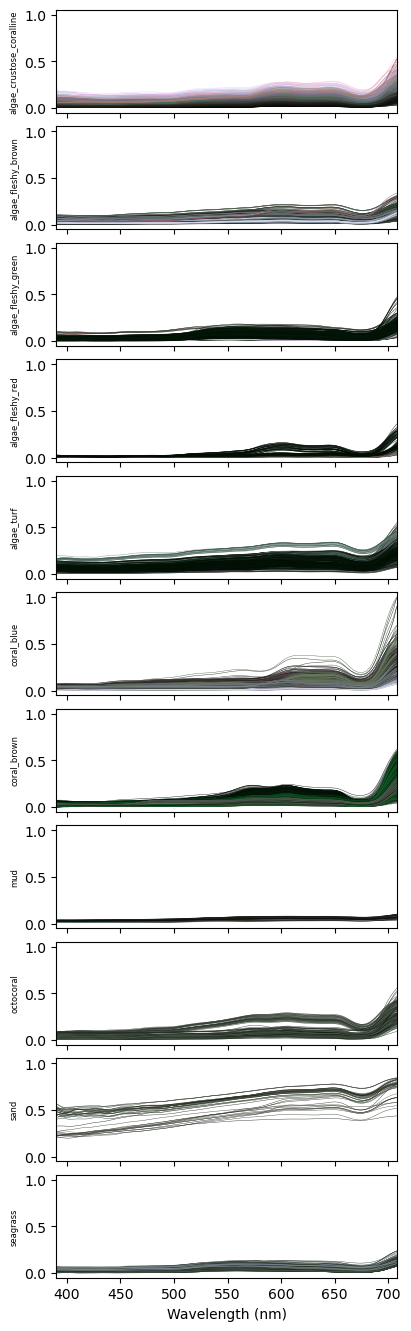

In [57]:
cats = df.index.unique()

fig, axs = plt.subplots(len(cats), 1, figsize=[4, len(cats) * 1.2], sharex=True, constrained_layout=True)

# color_dict = {c: plt.cm.tab20(i) for i, c in enumerate(cats)}

snum = 0
for cat, ax in zip(cats, axs):
    ind = df.index == cat
    spectra = df.loc[ind].values
    # calculate rgb values
    rgb_normed = plotting.generate_and_visualise_spectral_colours(df)
    
    for s, spectrum in enumerate(spectra):
        ax.plot(df.columns, spectrum, color=rgb_normed[s], alpha=1, lw=0.3)
        snum += 1
            
    ax.set_ylabel(cat, fontsize=6)
    # ax.set_yticks([])
    ax.set_xlim(min(df.columns), max(df.columns))

# set the y lims of the axes to be the same
ymin = min([ax.get_ylim()[0] for ax in axs])
ymax = max([ax.get_ylim()[1] for ax in axs])
[ax.set_ylim(ymin, ymax) for ax in axs]
ax.set_xlabel('Wavelength (nm)');

In [58]:
glob_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)

In [59]:
# create dictionary of colours for each endmember
color_dict = {
    "algae_crustose_coralline": (255,205,210),
    "algae_fleshy_brown": (130, 119, 23),
    "algae_fleshy_green": (129, 199, 132),
    "algae_fleshy_red": (255, 171, 145),
    "algae_turf": (230, 238, 156),
    "coral_blue": (178, 223, 219),
    "coral_brown": (161, 136, 127),
    "octocoral": (255, 193, 7),
    "mud": (121, 85, 72),
    "sand": (255, 248, 225),
    "seagrass": (27, 94, 32)
}

In [60]:
# Initialize an empty dictionary to store the combined colors
class_color_dict = {}

endmember_class_schema = "three_endmember"
endmember_classes = glob_cfg.endmember_schema[endmember_class_schema]


class_subclass_dict = endmember_classes
subclass_color_dict = color_dict
# Iterate over each class in class_subclass_dict
for class_name, subclasses in class_subclass_dict.items():
    # Fetch the colors of the subclasses
    subclass_colors = [subclass_color_dict[subclass] for subclass in subclasses]
    
    # Convert the list of colors to a numpy array for easy averaging
    subclass_colors_array = np.array(subclass_colors)
    
    # Average the RGB values
    combined_color = tuple(subclass_colors_array.mean(axis=0).astype(int))
    # normalise
    combined_color = tuple([c/255 for c in combined_color])
    # Store the combined color in the new dictionary
    class_color_dict[class_name] = combined_color
    


Text(0.5, 0, 'Wavelength (nm)')

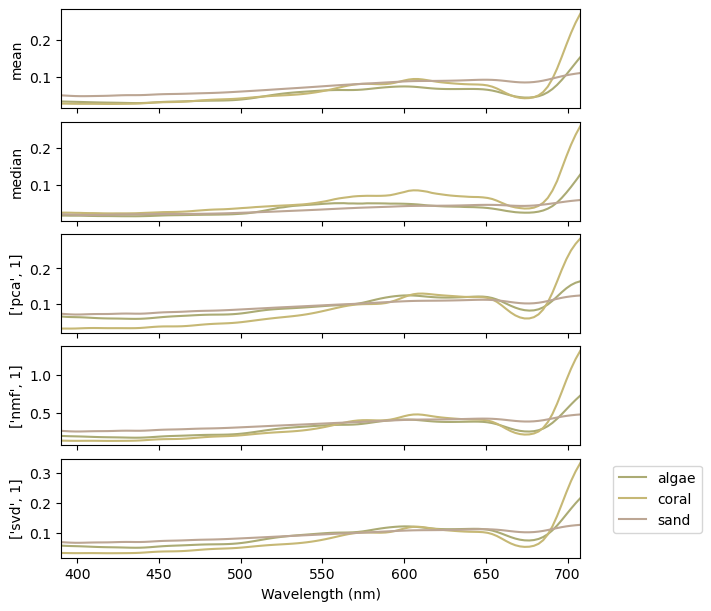

In [61]:
# visualise components of endmembers
dimensionality_reduction_types = ["mean", "median", ["pca", 1], ["nmf", 1], ["svd",1]]

fig, ax = plt.subplots(nrows=len(dimensionality_reduction_types), figsize=[7, len(dimensionality_reduction_types) * 1.2], sharex=True, constrained_layout=True)

endmember_class_schema = "three_endmember"
for i, dr in enumerate(dimensionality_reduction_types):
    endmembers = optimisation_pipeline.GenerateEndmembers(
        endmember_class_map = glob_cfg.endmember_schema[endmember_class_schema],
        endmember_dimensionality_reduction = dr
        ).generate_endmembers()
    for endmember in endmembers.index:
        if isinstance(endmember, tuple):
            endmember = endmember[0]
        ax[i].plot(df.columns, endmembers.loc[endmember].T, alpha=1, lw=1.5, color=class_color_dict[endmember])
    ax[i].set_ylabel(dimensionality_reduction_types[i])
    ax[i].set_xlim(min(df.columns), max(df.columns))

ax[-1].legend([em[0] for em in endmembers.index], bbox_to_anchor=(1.05,1), loc='upper left')
ax[-1].set_xlabel('Wavelength (nm)')

In [62]:
mean_spectra = df.groupby(df.index).mean()

# order mean_spectra by index containing 'algae' first, then 'coral', then 'seagrass', then 'sand', then 'mud'
mean_spectra = mean_spectra.reindex(mean_spectra.index[mean_spectra.index.str.contains('algae')].tolist() +
                                    mean_spectra.index[mean_spectra.index.str.contains('coral')].tolist() +
                                    mean_spectra.index[mean_spectra.index.str.contains('seagrass')].tolist() +
                                    mean_spectra.index[mean_spectra.index.str.contains('sand')].tolist() +
                                    mean_spectra.index[mean_spectra.index.str.contains('mud')].tolist())
mean_spectra

,390.346814,393.177859,396.008959,398.840115,401.671328,404.502597,407.333922,410.165304,412.996742,415.828236,...,682.239779,685.076616,687.913509,690.750458,693.587464,696.424526,699.261643,702.098818,704.936048,707.773335
wavelength,,,,,,,,,,,,,,,,,,,,,
algae_crustose_coralline,0.054358,0.053066,0.052221,0.051684,0.051110,0.050343,0.049509,0.048654,0.047874,0.047253,...,0.063754,0.068874,0.076957,0.088201,0.102432,0.118989,0.136883,0.154938,0.172149,0.187811
algae_fleshy_brown,0.031926,0.031671,0.031309,0.030959,0.030691,0.030505,0.030368,0.030230,0.030074,0.029920,...,0.044501,0.049467,0.056801,0.066644,0.078730,0.092362,0.106625,0.120562,0.133422,0.144806
algae_fleshy_green,0.014024,0.013959,0.013797,0.013604,0.013419,0.013249,0.013112,0.012989,0.012865,0.012720,...,0.024035,0.027507,0.032404,0.039075,0.047794,0.058637,0.071483,0.086025,0.101895,0.118748
algae_fleshy_red,0.009379,0.009427,0.009392,0.009281,0.009114,0.008951,0.008866,0.008854,0.008878,0.008888,...,0.017896,0.019350,0.021705,0.025442,0.031082,0.038986,0.049270,0.061751,0.075985,0.091402
algae_turf,0.065372,0.064816,0.064287,0.063847,0.063387,0.062791,0.062087,0.061372,0.060732,0.060237,...,0.094669,0.102151,0.113253,0.127994,0.145880,0.165866,0.186615,0.206804,0.225535,0.242391
algae_crustose_coralline,0.054358,0.053066,0.052221,0.051684,0.051110,0.050343,0.049509,0.048654,0.047874,0.047253,...,0.063754,0.068874,0.076957,0.088201,0.102432,0.118989,0.136883,0.154938,0.172149,0.187811
coral_blue,0.031437,0.031932,0.032391,0.032715,0.032833,0.032776,0.032649,0.032521,0.032438,0.032415,...,0.070383,0.083279,0.102807,0.129211,0.161253,0.196151,0.230557,0.261757,0.288571,0.311744
coral_brown,0.024920,0.024433,0.023914,0.023530,0.023354,0.023317,0.023335,0.023323,0.023235,0.023082,...,0.040652,0.048376,0.061449,0.081006,0.107036,0.138036,0.171328,0.203830,0.233238,0.258011
octocoral,0.034357,0.035312,0.035834,0.036481,0.037124,0.037494,0.037686,0.037681,0.037513,0.037248,...,0.076221,0.089434,0.109071,0.134892,0.165335,0.197756,0.229188,0.257137,0.280307,0.298481


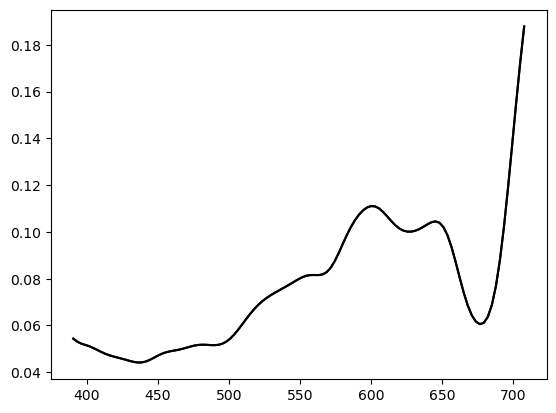

In [63]:
plt.plot(mean_spectra.columns, mean_spectra[mean_spectra.index == "algae_crustose_coralline"].values.T, color='black', lw=1.5, label='Mean')

algae_crustose_coralline
algae_fleshy_brown
algae_fleshy_green
algae_fleshy_red
algae_turf
algae_crustose_coralline
coral_blue
coral_brown
octocoral
seagrass
sand
mud


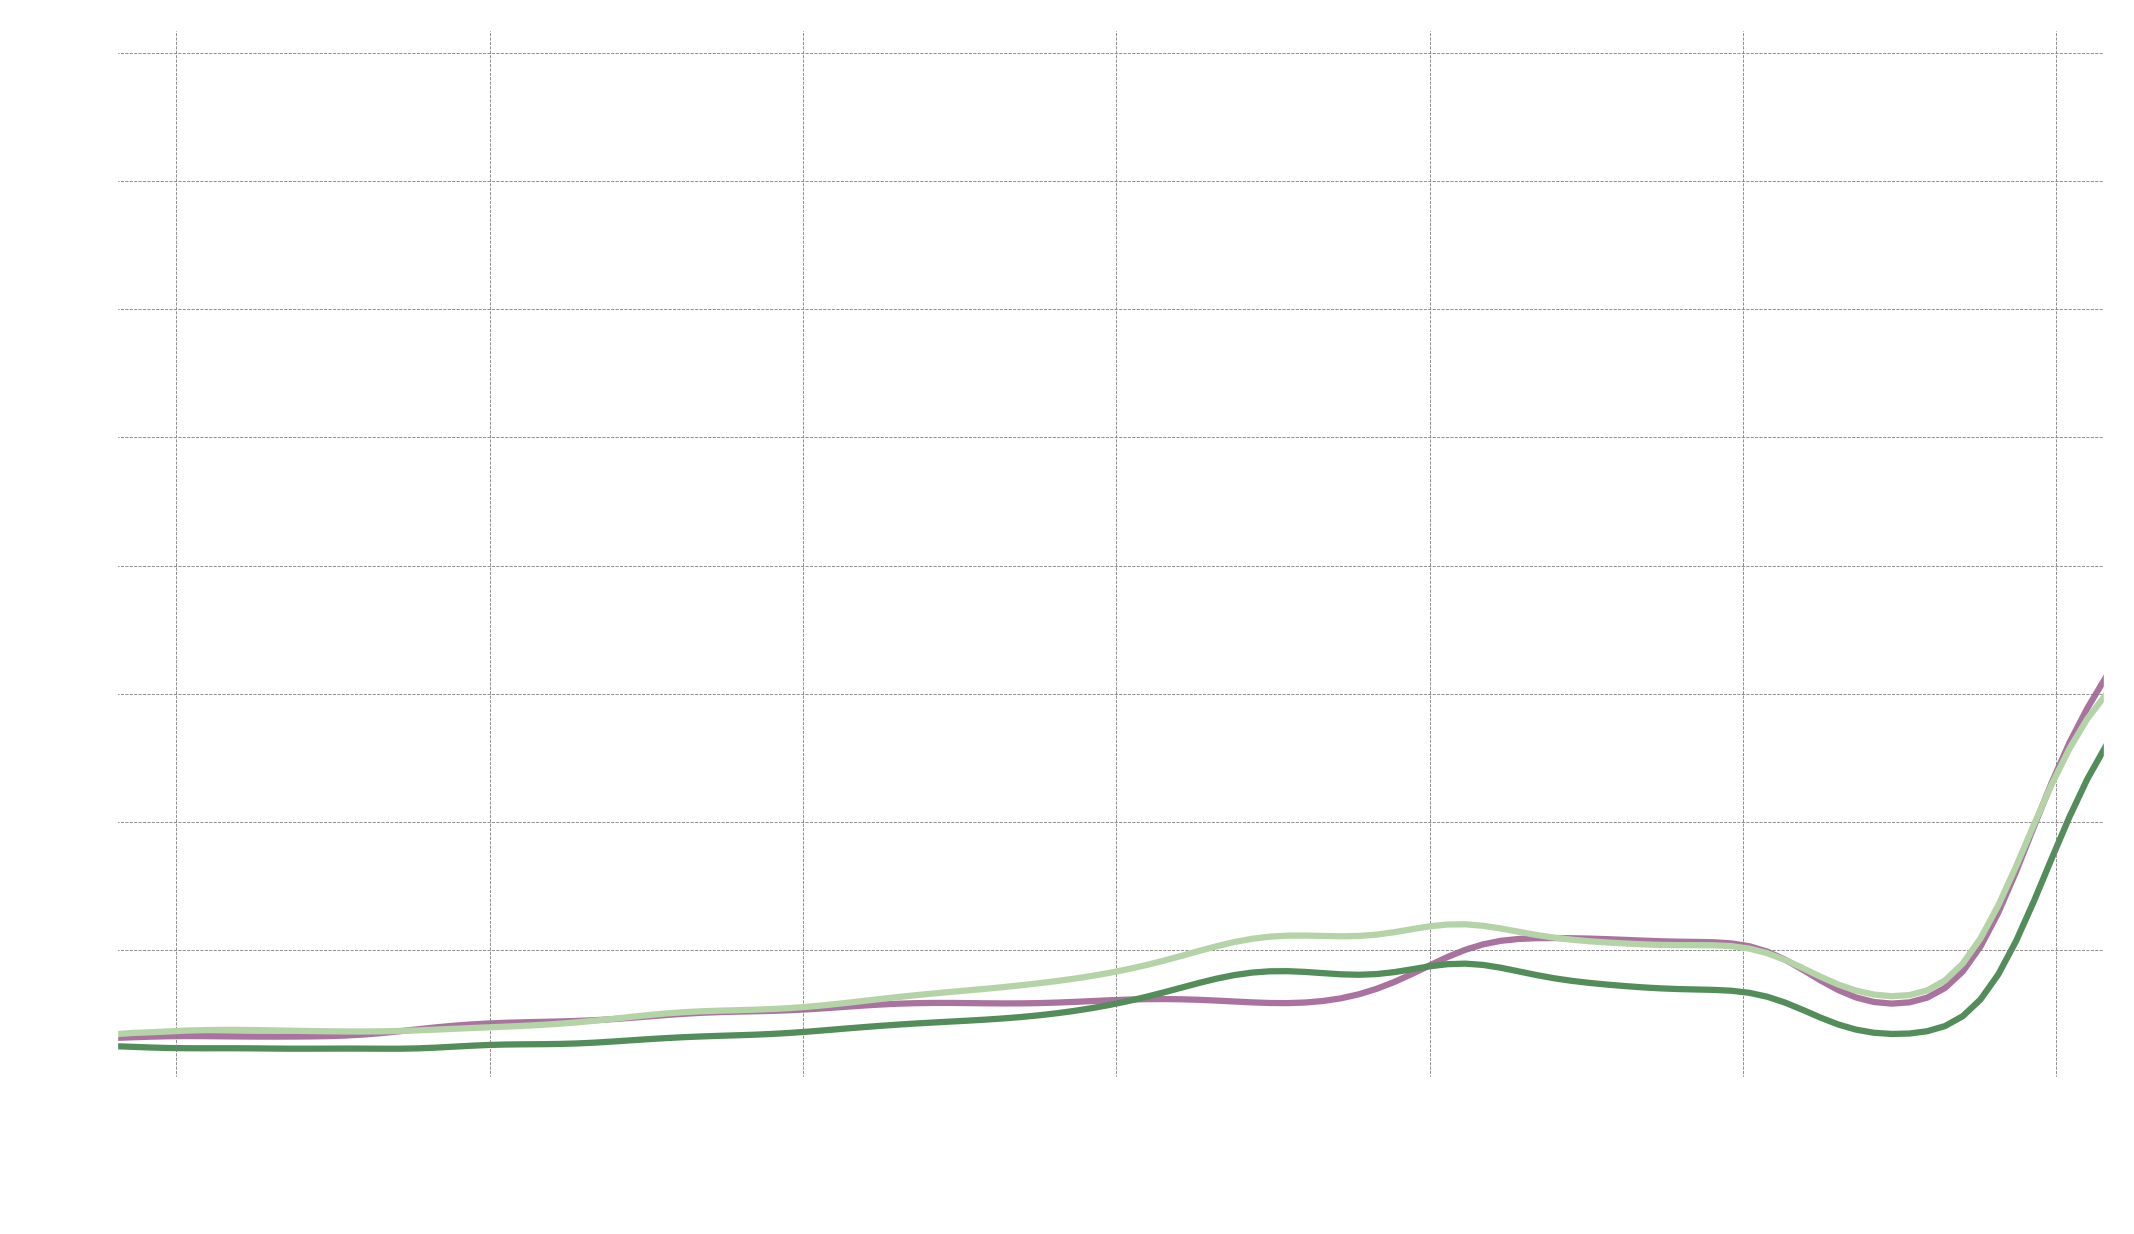

In [64]:
# exclude sand row
no_sand_mean_spectra = mean_spectra.drop('sand')
rgb_colours = plotting.generate_and_visualise_spectral_colours(no_sand_mean_spectra)
rgb_colours = np.concatenate((rgb_colours, [[0, 1, 1]]))

# create dictionary of names and colours
color_dict = dict(zip(mean_spectra.index, rgb_colours))
# plot all containing algae
fig, ax = plt.subplots(figsize=[7, 4], constrained_layout=True, dpi=300)


classes_to_plot = [
    # 'algae',
    # 'crustose',
    'coral',
    # 'seagrass',
    # 'sand`'
    ]
order = 0
for i, (index, spectra) in enumerate(mean_spectra.iterrows()):
    print(index)
    if any([c in index for c in classes_to_plot]):
        # only plot crustose if 'crustose' is in classes to plot
        if 'crustose' in index and 'crustose' not in classes_to_plot:
            continue
        else:
            ax.plot(df.columns, spectra, color=rgb_colours[i], alpha=1, lw=1.5, zorder=order)
            order += 1
        
# format
ax.set_xlabel('Wavelength (nm)', color="white")
fig.patch.set_alpha(0.0)
ax.patch.set_alpha(0.0)
ax.set_ylim(0, np.max(mean_spectra.values)*1.1)
ax.set_xlim(min(df.columns), max(df.columns))
plotting.format_axis_for_ppt(ax)
ax.set_yticklabels([])
ax.set_ylabel('Reflectance', color="white")
ax.grid(True, color="#7D7D7D", ls='--', linewidth=0.2, alpha=1, which='both')
# save result
fn = "mean_" + "_".join(classes_to_plot) + "_spectra"
fig.savefig(file_ops.RESULTS_DIR_FP / f"figures/{fn}.png", dpi=300, transparent=True)

In [71]:
mean_spectra.index

Index(['algae_crustose_coralline', 'algae_fleshy_brown', 'algae_fleshy_green',
       'algae_fleshy_red', 'algae_turf', 'algae_crustose_coralline',
       'coral_blue', 'coral_brown', 'octocoral', 'seagrass', 'sand', 'mud'],
      dtype='object', name='wavelength')

In [73]:
# remap classes
map_dict = {
    'algae_crustose_coralline': "CCA", 
    'algae_fleshy_brown': "brown algae",
    'algae_fleshy_green': "green algae",
    'algae_fleshy_red': "red algae",
    'algae_turf': "turf algae",
    'coral_blue': "blue coral",
    'coral_brown': "brown coral",
    'octocoral': "octocoral",
    'seagrass': 'seagrass',
    'mud': "mud",
    'sand': 'sand',
}
# rename df indices
remapped_df = df.copy()
remapped_df.index = [map_dict[c] for c in remapped_df.index]
color_dict = dict(zip(remapped_df.index.unique(), rgb_colours))


In [74]:
remapped_df.index.unique()

Index(['CCA', 'brown algae', 'green algae', 'red algae', 'turf algae',
       'blue coral', 'brown coral', 'mud', 'octocoral', 'sand', 'seagrass'],
      dtype='object')

In [79]:
# create a dictionary of colours from a colormap
cmap = plt.cm.get_cmap('tab20', len(remapped_df.index.unique()))
# get the colours
colors = cmap.colors
colors

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_33380/2316449965.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(remapped_df.index.unique()))


array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [1.        , 0.49803922, 0.05490196, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.83921569, 0.15294118, 0.15686275, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.54901961, 0.3372549 , 0.29411765, 1.        ],
       [0.89019608, 0.46666667, 0.76078431, 1.        ],
       [0.49803922, 0.49803922, 0.49803922, 1.        ],
       [0.7372549 , 0.74117647, 0.13333333, 1.        ],
       [0.09019608, 0.74509804, 0.81176471, 1.        ],
       [0.61960784, 0.85490196, 0.89803922, 1.        ]])

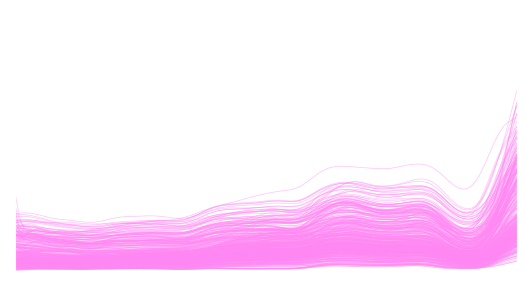

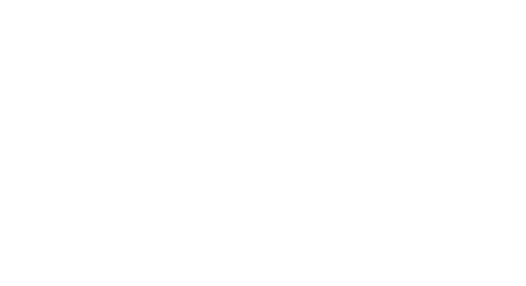

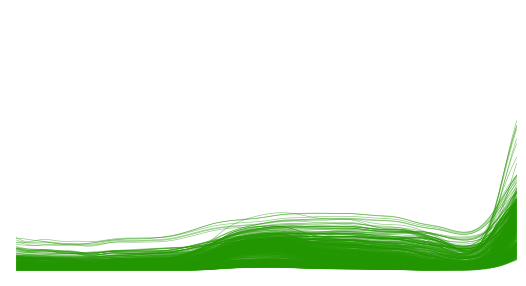

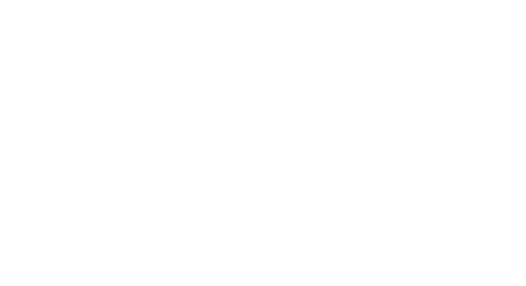

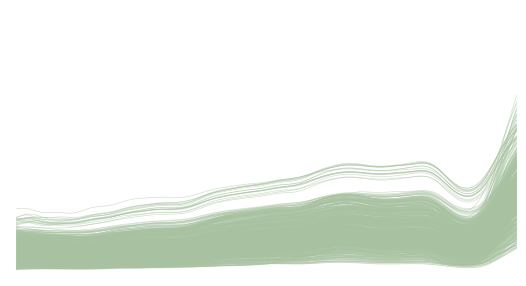

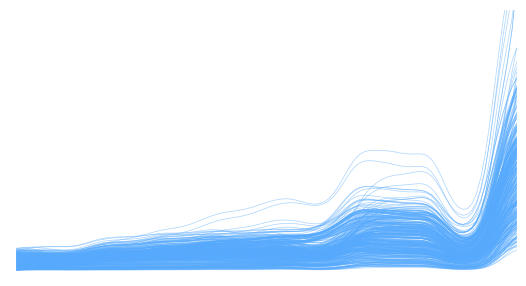

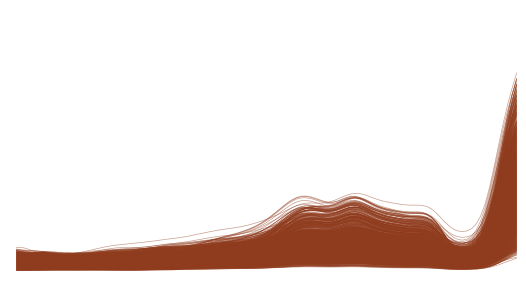

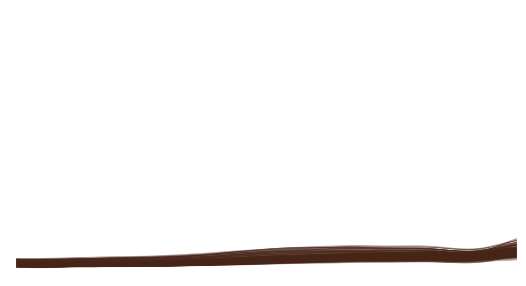

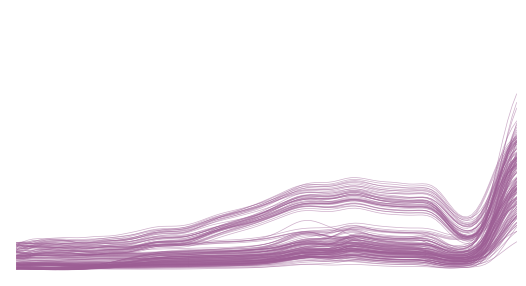

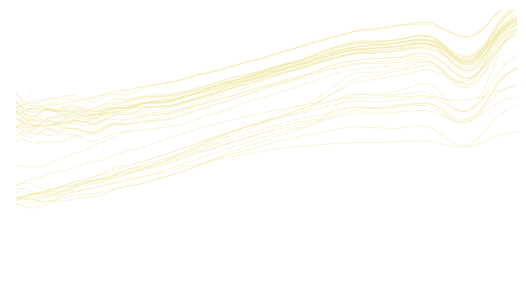

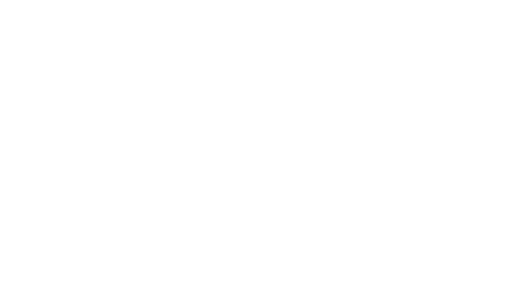

In [86]:
# plot each class with the correct colour

color_dict = {
    'CCA': "#ff87f3",
    'brown algae': "#FFFFFF",
    'green algae': "#219600",
    'red algae': "#FFFFFF",
    'turf algae': "#a8c2a1",
    'blue coral': "#56a9fc",
    'brown coral': "#8f3b1d",
    'mud': "#472418",
    'octocoral': "#9c5d94",
    'sand': "#f0e497",
    'seagrass': "#FFFFFF",
}
for i, cat in enumerate(remapped_df.index.unique()):
    fig, ax = plt.subplots(figsize=[5.15, 2.75], constrained_layout=True)
    # ax.plot(remapped_df.columns, remapped_df.loc[cat].T, color=color_dict[cat], lw=0.5, alpha=0.5)
    ax.plot(remapped_df.columns, remapped_df.loc[cat].T, color=color_dict[cat], lw=0.5, alpha=0.5)
    # ax.set_xlabel('Wavelength (nm)', color="white")
    fig.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)
    ax.set_ylim(0, np.max(mean_spectra.values)*1.1)
    ax.set_xlim(min(remapped_df.columns), max(remapped_df.columns))
    plotting.format_axis_for_ppt(ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    # ax.set_ylabel('Reflectance', color="white")
    ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
    ax.text(
        0.5, 0.9, cat, 
        horizontalalignment='center', 
        verticalalignment='center', 
        transform=ax.transAxes,
        fontsize=10,
        color='white'
    )
    fig.savefig(file_ops.RESULTS_DIR_FP / f"figures/all_{cat}.png", dpi=300, transparent=True)

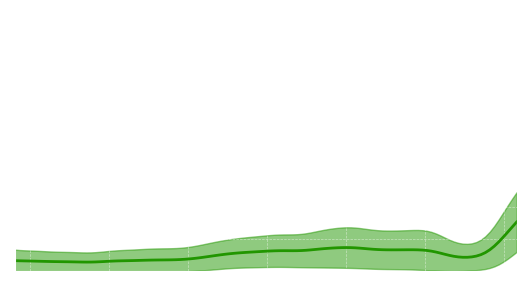

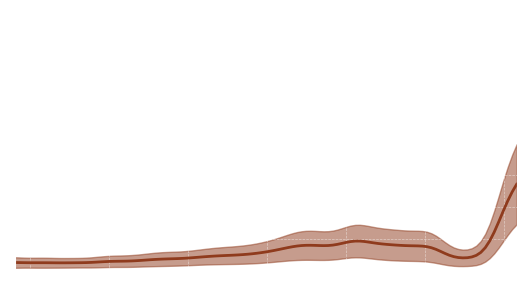

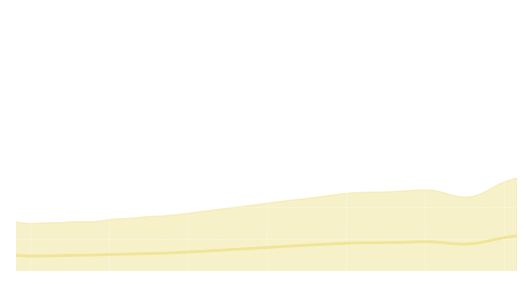

In [102]:
# plot mean coral, mean algae, mean geological
# remap classes
three_em_cats = {
    'algae': ['algae_fleshy_brown', 'algae_fleshy_green', 'algae_fleshy_red', 'algae_turf', 'seagrass', 'algae_crustose_coralline'],
    'coral': ['coral_blue', 'coral_brown', 'octocoral'],
    'sand': ['sand', 'mud']
}

three_em_cats = {
    'algae': ['algae_fleshy_brown', 'algae_fleshy_green', 'algae_fleshy_red', 'algae_turf', 'seagrass', 'algae_crustose_coralline'],
    'coral': ['coral_blue', 'coral_brown', 'octocoral'],
    'sand': ['sand', 'mud']
}
wvs = df.columns
three_endmembers = {}
std_three_endmembers = {}
for cat in three_em_cats:
    ind = df.index.isin(three_em_cats[cat])
    # select all spectra in category and calculate mean spectrum
    three_endmembers[cat] = df.loc[ind].mean(axis=0).loc[wvs]
    std_three_endmembers[cat] = df.loc[ind].std(axis=0).loc[wvs]
# create array of average spectrum for each category
three_endmember_array = np.array([spectrum.values for spectrum in three_endmembers.values()])
three_color_dict = {
    'algae': "#219600",
    "coral": "#8f3b1d",
    "sand": "#f0e497",
}
for cat, spectrum in three_endmembers.items():
    fig, ax = plt.subplots(figsize=[5.15, 2.75], constrained_layout=True)
    ax.plot(spectrum.index, spectrum.values, color=three_color_dict[cat], lw=2, alpha=1)
    ax.fill_between(spectrum.index, spectrum.values - std_three_endmembers[cat].values, spectrum.values + std_three_endmembers[cat].values, color=three_color_dict[cat], alpha=0.5)
    # ax.plot(remapped_df.columns, remapped_df.loc[cat].T, color=color_dict[cat], lw=0.5, alpha=0.5)
    # ax.set_xlabel('Wavelength (nm)', color="white")
    fig.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)
    ax.set_ylim(0, np.max(mean_spectra.values)*1.1)
    ax.set_xlim(min(remapped_df.columns), max(remapped_df.columns))
    plotting.format_axis_for_ppt(ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    # ax.set_ylabel('Reflectance', color="white")
    ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
    ax.text(
        0.5, 0.9, cat, 
        horizontalalignment='center', 
        verticalalignment='center', 
        transform=ax.transAxes,
        fontsize=16,
        color='white'
    )

array([0.04940937, 0.04871048, 0.04800786, 0.04747914, 0.04721378,
       0.04719922, 0.04734578, 0.04755671, 0.04776612, 0.04798069,
       0.04827577, 0.04870765, 0.04920712, 0.04964645, 0.0499017 ,
       0.04996734, 0.04995689, 0.05006628, 0.0504288 , 0.05098794,
       0.05162329, 0.05220525, 0.05263771, 0.05291444, 0.05311149,
       0.05331691, 0.05358199, 0.05393241, 0.05433219, 0.05472221,
       0.05507283, 0.05539356, 0.05572399, 0.05611554, 0.05660115,
       0.0571741 , 0.0578162 , 0.05850755, 0.05922885, 0.05996574,
       0.06071356, 0.06146559, 0.06222064, 0.06299202, 0.06378792,
       0.06460844, 0.06544285, 0.06627651, 0.06709563, 0.06790143,
       0.06870267, 0.06950804, 0.07032413, 0.07115668, 0.07200408,
       0.07286647, 0.07374357, 0.07462824, 0.07550892, 0.07637168,
       0.07720424, 0.0779939 , 0.07874345, 0.07946279, 0.0801685 ,
       0.08087656, 0.08159486, 0.08232239, 0.0830517 , 0.0837778 ,
       0.08450103, 0.08522981, 0.08596527, 0.08668532, 0.08734

MovieWriter Pillow unavailable; using Pillow instead.


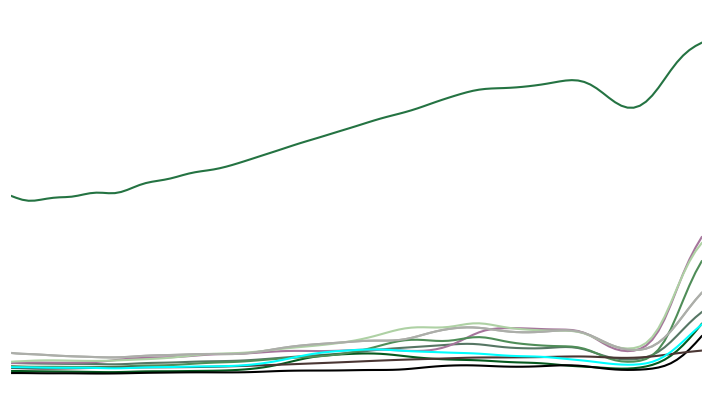

In [96]:
# fig, ax = plt.subplots(figsize=[7, 4], constrained_layout=True)

# ax.set_ylim(0, np.max(no_sand_mean_spectra.values) * 1.1)

# def update(frame):
#     if frame < 10:
#         ax.plot(mean_spectra.columns, mean_spectra.values[frame], color=RGB_COLOURS[frame], lw=1.5)
#     else:
#         # clear plot
#         ax.clear()
#         plotting.format_axis_for_ppt(ax)
#         ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.05, which='both')
#         ax.set_yticks([])
#         ax.set_xlim(min(mean_spectra.columns), max(mean_spectra.columns))
#         for i, line in enumerate(mean_spectra.values):
#             ax.plot(mean_spectra.columns, line, color=np.concatenate((RGB_COLOURS, [[0, 1, 1]]))[i], lw=1.5)
#         ax.set_ylim(0, np.max(mean_spectra.values) * 1.1)
#     # format axis
#     plotting.format_axis_for_ppt(ax)
#     ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.05, which='both')
#     ax.set_yticks([])
#     ax.set_xlim(min(mean_spectra.columns), max(mean_spectra.columns))
#     return ax

# fig.patch.set_alpha(0.0)
# ax.patch.set_alpha(0.0)
# ani = FuncAnimation(fig, update, frames=range(mean_spectra.shape[0]), interval=250, repeat=False)

# # save with transparency
# ani.save(file_ops.RESULTS_DIR_FP / "figures/mean_spectra.gif", writer='Pillow', fps=3, dpi=300, savefig_kwargs={'transparent': True})


### PCA

(390.3468145, 707.7733348)

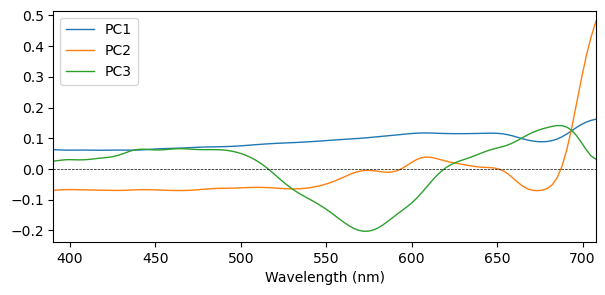

In [47]:

# N-component PCA
pca = PCA(3)
pca.fit_transform(df)

fig, ax = plt.subplots(figsize=[7, 3])
for i, component in enumerate(pca.components_):
    ax.plot(df.columns, component, label=f'PC{i+1}', lw=1)
ax.hlines(0, df.columns.min(), df.columns.max(), color='k', lw=0.5, ls='--')

# formatting
ax.legend()
ax.set_xlabel('Wavelength (nm)')
ax.set_xlim(df.columns.min(), df.columns.max())

In [45]:
pca.explained_variance_ratio_.cumsum()

array([0.91105596, 0.97373966, 0.98561967])

### Truncated SVD

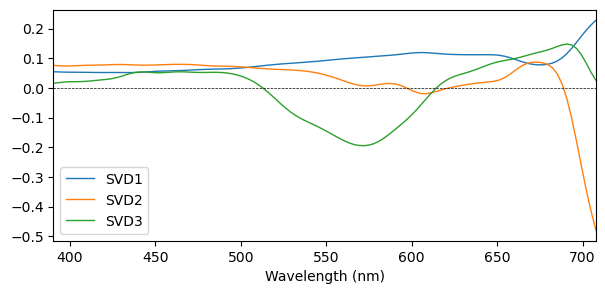

In [46]:
svd = TruncatedSVD(3)
svd.fit_transform(df)

fig, ax = plt.subplots(figsize=[7, 3])
for i, component in enumerate(svd.components_):
    ax.plot(df.columns, component, label=f'SVD{i+1}', lw=1)
ax.hlines(0, df.columns.min(), df.columns.max(), color='k', lw=0.5, ls='--')
 
# formatting
ax.set_xlabel('Wavelength (nm)')
ax.set_xlim(df.columns.min(), df.columns.max())
ax.legend()    

In [43]:
svd.explained_variance_ratio_.cumsum()

array([0.8979756 , 0.97263838, 0.98511882])